In [96]:
import torch
from torch import nn
from torch import optim
from torch.distributions import Categorical
import torch.nn.functional as F
from gym_minigrid.wrappers import *
from gym import wrappers
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange

%matplotlib inline

ModuleNotFoundError: No module named 'MiniGridEnv'

In [125]:
DEVICE = 'cuda'

def make_env(max_steps=100):
    env = gym.make('MiniGrid-FourRooms-v0')
    env.max_steps = max_steps
    env.env.max_steps = max_steps
    env = RGBImgPartialObsWrapper(env) # Get pixel observations
    env = ImgObsWrapper(env) # Get rid of the 'mission' field
    # obs = env.reset() # This now produces an RGB tensor only
    return env

def render_state(env):
    img = env.render(mode='rgb_array')
    plt.imshow(img)
    plt.show()

def preprocess_obs(obs):
    obs = torch.Tensor(obs).float().to(DEVICE)
    obs /= 255.0
    if len(obs.shape) == 3:
        obs = rearrange(obs, 'h w c -> 1 c h w')
    elif len(obs.shape) == 4:
        obs = rearrange(obs, 'b h w c -> b c h w')
    else:
        raise ValueError('Invalid obs shape')
    return obs

In [126]:
# Simple CNN implementation that take takes as input a 2D image (of shape 56, 56, 3),
# and outputs a single value.
class SRNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

N_ACTS = 7
class ActorNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, N_ACTS)
    
        self._init_weights()

    def _init_weights(self):
        self.fc3.weight.data.fill_(0)
        self.fc3.bias.data.fill_(0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [127]:
n_episodes = 200
max_steps = 1000
gamma = 0.99

env = make_env(max_steps)

sr_net = SRNetwork().to(DEVICE)
actor_net = ActorNetwork().to(DEVICE)

sr_lr = 0.001
actor_lr = 0.001

sr_optimizer = optim.Adam(sr_net.parameters(), sr_lr)
actor_optimizer = optim.Adam(actor_net.parameters(), actor_lr)

In [129]:
rewards = []
for episode in range(n_episodes):
    done = False
    obs = env.reset()
    obs = preprocess_obs(obs)
    step = 0
    rollout_rewards = []
    while not done:
        act_logits = actor_net(obs)
        print(act_logits)
        act = Categorical(logits=act_logits).sample()

        next_obs, reward, done, _ = env.step(act)
        next_obs = preprocess_obs(next_obs)
        rollout_rewards.append(reward)

        obs = next_obs
        step += 1
    
    rewards.append(np.sum(rollout_rewards))
    print(rewards[-1])
    print('N steps:', step)

tensor([[0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0., 0., 0., 0., 0., 0.,

KeyboardInterrupt: 

In [66]:
sr_net = SRNetwork().to(DEVICE)
obs = env.reset()
obs = preprocess_obs(obs)
out = sr_net(obs)

In [67]:
out.shape

torch.Size([1, 1])

In [63]:
env.reset().shape

(56, 56, 3)

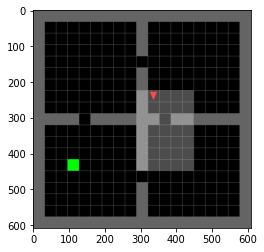

In [59]:
render_state(env)

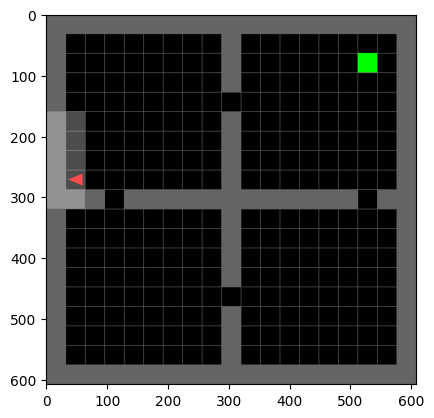

In [41]:
plt.imshow(img)

plt.show()

In [20]:
obs['image'].reshape(-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 2, 5, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 1, 0, 0], dtype=uint8)

C:\Users\ninja\.conda\envs\ml2\lib\site-packages\gym_minigrid\window.py:26: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  self.fig.canvas.set_window_title(title)


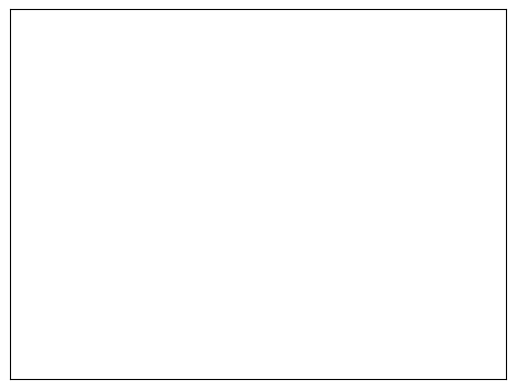

array([[[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       ...,

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]]

In [22]:
env.render()